## Continuous T1 

This reads out the state of the qubit at t = T1 continuously. We recalibrate the qubit after some variable time. The qubit is assumed to be calibrated and the data saved to the cfg file 

# ------------ Initializations ------------

In [11]:
# %matplotlib widget
%matplotlib inline

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
import scipy as sp
import json
import cProfile
import re 
import datetime
from timeit import default_timer as timer

from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict
from datetime import datetime
import h5py


# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas


imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.DONOTUSE_ramsey_ef
imported experiments.single_qubit.DONOTUSE_randbench
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy_test
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.SingleRB
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.single_shot_ziqian
imported experiments.single_qubit.t1
imported experiments.single_qubit.t1_2qb
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported exp

In [3]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [4]:
expt_path=os.getcwd()+'\data'
data_path = "C:\_Data\LLqub_contT1"
print('Continuous T1 Data will be stored in', data_path)
print('SLAB data will be stored in', expt_path) 

Continuous T1 Data will be stored in C:\_Data\LLqub_contT1
SLAB data will be stored in c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data


Import the cfg file: 

In [6]:
import yaml
# Results config file:
results_config_file = 'autocalibration_cfg.yml'
results_config_path = os.getcwd() + '\\' + results_config_file
print('Results config will be', results_config_path)

# open the file 
with open(results_config_file,'r') as file:
  auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary 

def save_edits( file_name, edit_config, edit_list, qubit_i,  value):
    print('Assumes edit_list is already in edit_config')
    print('If it is not, it will not update edit_config')
    # open the file 
    # edit the file
    edit_list[qubit_i] = value
    # dump it: 
    edit_config= yaml.safe_dump(edit_config.to_dict(), default_flow_style=  True)

    # write it: 
    with open(file_name, 'w') as modified_file:
        modified_file.write(edit_config)

    # now, open the modified file again 
    with open(file_name,'r') as file:
      edit_config=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary 
    return edit_config

Results config will be c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\autocalibration_cfg.yml


In [8]:
im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab

soc = QickConfig(im[auto_cfg['aliases']['soc']].get_cfg())
print(soc)
print(auto_cfg['aliases']['soc'])
print(soc.description())



QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v4 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	1:	axis_signal_gen_v4 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	2:	axis_signal_gen_v4 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, ch 2, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	3:	axis_signal_gen_v4 - tProc output 4, envelope memory 65536 samples
		DAC tile 2, ch 3, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	4:	axis_signal_gen_v4 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v4 - tProc output 6, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	6:	axis_signal_gen_v4 - tProc out

215 307
readout freq 0 +/- 7098.096441938447


  0%|          | 0/1000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00022_adc_trig_offset_calibration_qubit0.h5


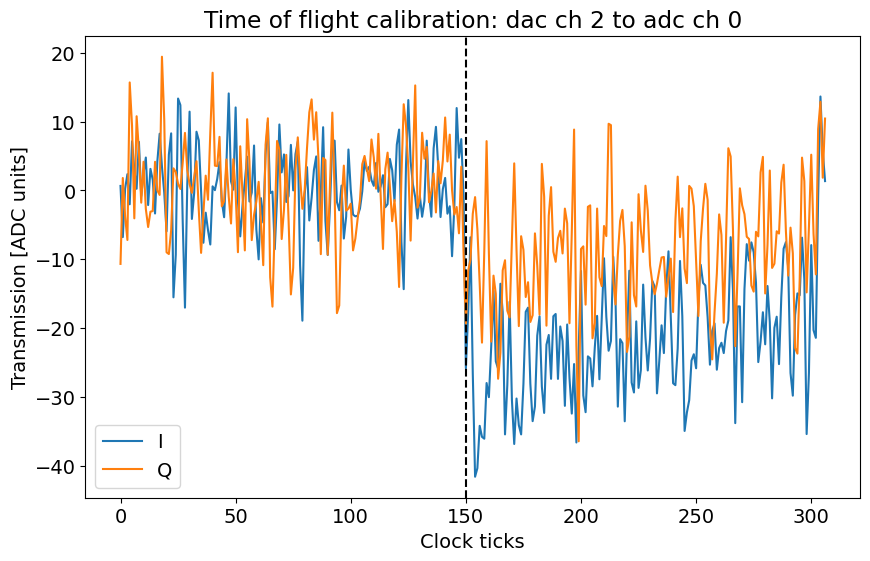

In [9]:
qubit_i = 0
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=results_config_path,
)

tof.cfg.expt = dict(
    pulse_length=0.5, # [us]
    readout_length=1.0, # [us]
    trig_offset=0, # [clock ticks]
    gain=30000, # blast the power just for the RFSoC calibration
    # gain=5000, # [MUX units: -1 to 1]
    frequency=tof.cfg.device.readout.frequency[qubit_i], # [MHz]
    reps=1000, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)
tof.cfg.device.readout.relax_delay=0.1 # wait time between experiments [us]

import Pyro4.util
try: 
    tof.go(analyze=False, display=False, progress=True, save=True)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

tof.display(adc_trig_offset=150) 

## Run the T1 

In [25]:
def run_continuous_t1(qubit_i):
    t1_cont = meas.T1Continuous(
        soccfg=soc,
        path=expt_path,
        prefix=f"t1_continuous_qubit{qubit_i}",
        config_file=results_config_path,
    )

    span = auto_cfg.device.qubit.T1[qubit_i]
    npts = 1

    t1_cont.cfg.expt = dict(
        start=span / npts,  # wait time [us]
        step=0,
        expts=npts,
        reps= 1000000,  # number of times we repeat a time point
        rounds=1,  # number of start to finish sweeps to average over
        qubit=qubit_i,
    )

    t1_cont.go(analyze=False, display=False, progress=True, save=False)
    t1_raw_i = t1_cont.data['raw_i']
    t1_raw_q = t1_cont.data['raw_q']
    t1_amps = t1_cont.data['raw_amps']

    return t1_raw_i, t1_raw_q, t1_amps
pass

def run_t1_recalibration(qubit_i):
    t1 = meas.T1Experiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"t1_qubit{qubit_i}",
        config_file=results_config_path,
        )

    span = 600
    npts = 100

    t1.cfg.expt = dict(
        start=0,  # wait time [us]
        step=int(span / npts),
        expts=npts,
        reps= 100*5,  # number of times we repeat a time point
        rounds=1,  # number of start to finish sweeps to average over
        qubit=qubit_i,
        length_scan=span,  # length of the scan in us
        num_saved_points=1,  # number of points to save for the T1 continuous scan
        )

    t1.go(analyze=False, display=False, progress=True, save=False)
    t1.analyze(fit=True)
    t1_err_i = np.sqrt(t1.data['fit_err_avgi'][3][3])
    t1_fit_i =t1.data['fit_avgi'][3]
    err_ratio_i = t1_err_i/t1_fit_i

    t1_err_q = np.sqrt(t1.data['fit_err_avgq'][3][3])
    t1_fit_q =t1.data['fit_avgq'][3]
    err_ratio_q = t1_err_q/t1_fit_q

    # open the results config file 
    with open(results_config_file,'r') as file:
        auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary

    if err_ratio_i< err_ratio_q:
        print('t1_i is better, saving T1_i to results cfg file') 
        auto_cfg.device.qubit.T1[qubit_i] = float(t1_fit_i)  # [DAC units]  

    else: 
        print('t1_q is better, saving t1_q to results cfg file')
        auto_cfg.device.qubit.T1[qubit_i] = float(t1_fit_q)  # [DAC units]  

    auto_cfg= yaml.safe_dump(auto_cfg.to_dict(), default_flow_style=  True) # dump it 

    # write it: 
    with open('autocalibration_cfg.yml', 'w') as modified_file:
        modified_file.write(auto_cfg)
    # now, open the modified file again 
    with open('autocalibration_cfg.yml','r') as file:
        auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary
    
    t1_i = t1.data['avgi']
    t1_q = t1.data['avgq']
    t1_amp = t1.data['amps']
    t1_i_value = t1.data['fit_avgi'][3]
    t1_q_value = t1.data['fit_avgq'][3]
    t1_amp_value = t1.data['fit_amps'][3]
    t1_i_value_err = t1.data['fit_err_avgi'][3][3]
    t1_q_value_err = t1.data['fit_err_avgq'][3][3]
    t1_amp_value_err = t1.data['fit_err_amps'][3][3]

    return t1_i, t1_q, t1_amp, t1_i_value, t1_q_value, t1_amp_value, t1_i_value_err, t1_q_value_err, t1_amp_value_err
pass


def main():
    # Get the current date and time
    import datetime
    current_datetime = datetime.datetime.now()
    formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

    # Create the filename using the formatted date and time
    filename = os.path.join(data_path, f"{formatted_datetime}.h5")

    # Create an HDF5 file to save all the data
    hf = h5py.File(filename, 'a')

    if 't1_cont' not in hf:
        g1 = hf.create_group('t1_cont')
        g1.create_dataset('i', data=np.array([]), maxshape=(None,))
        g1.create_dataset('q', data=np.array([]), maxshape=(None,))
        g1.create_dataset('amp', data=np.array([]), maxshape=(None,))

    if 't1_recal' not in hf:
        g2 = hf.create_group('t1_recal')
        g2.create_dataset('i', data=np.array([]), maxshape=(None,))
        g2.create_dataset('q', data=np.array([]), maxshape=(None,))
        g2.create_dataset('amp', data=np.array([]), maxshape=(None,))
        g2.create_dataset('i_value', data=np.array([]), maxshape=(None,))
        g2.create_dataset('q_value', data=np.array([]), maxshape=(None,))
        g2.create_dataset('amp_value', data=np.array([]), maxshape=(None,))
        g2.create_dataset('i_value_err', data=np.array([]), maxshape=(None,))
        g2.create_dataset('q_value_err', data=np.array([]), maxshape=(None,))
        g2.create_dataset('amp_value_err', data=np.array([]), maxshape=(None,))

    qubit_i = 0
    # Initialize arrays
    t1_raw_i_data, t1_raw_q_data, t1_amps_data = np.array([]), np.array([]), np.array([])
    
    t1_i_recal_data, t1_q_recal_data, t1_amp_recal_data, t1_i_value_recal_data, t1_q_value_recal_data, t1_amp_value_recal_data, t1_i_value_recal_data_err, t1_q_value_recal_data_err, t1_amp_value_recal_data_err= np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([])  

    start_time = timer()
    try:
        while True:
            # Run the continuous T1 experiment
            t1_raw_i_data, t1_raw_q_data, t1_amps_data = run_continuous_t1(qubit_i)

            # Append new data to datasets
            hf['t1_cont/i'].resize((hf['t1_cont/i'].shape[0] + t1_raw_i_data.shape[0]), axis=0)
            hf['t1_cont/i'][-t1_raw_i_data.shape[0]:] = t1_raw_i_data

            hf['t1_cont/q'].resize((hf['t1_cont/q'].shape[0] + t1_raw_q_data.shape[0]), axis=0)
            hf['t1_cont/q'][-t1_raw_q_data.shape[0]:] = t1_raw_q_data

            hf['t1_cont/amp'].resize((hf['t1_cont/amp'].shape[0] + t1_amps_data.shape[0]), axis=0)
            hf['t1_cont/amp'][-t1_amps_data.shape[0]:] = t1_amps_data
           
            print('Continuous data appended to', filename)

            end_time = timer()

            if end_time - start_time >= 60*30:
                print(f"{end_time - start_time} seconds have passed. Running T1 recalibration.")

                # Run the T1 recalibration experiment
                t1_i_recal_data, t1_q_recal_data, t1_amp_recal_data, t1_i_value_recal_data, t1_q_value_recal_data, t1_amp_value_recal_data, t1_i_value_recal_data_err, t1_q_value_recal_data_err, t1_amp_value_recal_data_err = run_t1_recalibration(qubit_i)

                print(t1_i_value_recal_data, t1_q_value_recal_data, t1_amp_value_recal_data)

                print(np.shape(t1_i_value_recal_data), np.shape(t1_q_value_recal_data), np.shape(t1_amp_value_recal_data))
                hf['t1_recal/i'].resize((hf['t1_recal/i'].shape[0] + t1_i_recal_data.shape[0]), axis=0)
                hf['t1_recal/i'][-t1_i_recal_data.shape[0]:] = t1_i_recal_data

                hf['t1_recal/q'].resize((hf['t1_recal/q'].shape[0] + t1_q_recal_data.shape[0]), axis=0)
                hf['t1_recal/q'][-t1_q_recal_data.shape[0]:] = t1_q_recal_data

                hf['t1_recal/amp'].resize((hf['t1_recal/amp'].shape[0] + t1_amp_recal_data.shape[0]), axis=0)
                hf['t1_recal/amp'][-t1_amp_recal_data.shape[0]:] = t1_amp_recal_data

                # T1 values for I, Q, and amp: 
                hf['t1_recal/i_value'].resize((hf['t1_recal/i_value'].shape[0] + 1), axis=0)
                hf['t1_recal/i_value'][-1:] = t1_i_value_recal_data

                hf['t1_recal/q_value'].resize((hf['t1_recal/q_value'].shape[0] + 1), axis=0)
                hf['t1_recal/q_value'][-1:] = t1_q_value_recal_data

                hf['t1_recal/amp_value'].resize((hf['t1_recal/amp_value'].shape[0] + 1), axis=0)
                hf['t1_recal/amp_value'][-1:] = t1_amp_value_recal_data

                # T1 errors for I, Q, and amp:  
                hf['t1_recal/i_value_err'].resize((hf['t1_recal/i_value_err'].shape[0] + 1), axis=0)
                hf['t1_recal/i_value_err'][-1:] = t1_i_value_recal_data_err

                hf['t1_recal/q_value_err'].resize((hf['t1_recal/q_value_err'].shape[0] + 1), axis=0)
                hf['t1_recal/q_value_err'][-1:] = t1_q_value_recal_data_err

                hf['t1_recal/amp_value_err'].resize((hf['t1_recal/amp_value_err'].shape[0] + 1), axis=0)
                hf['t1_recal/amp_value_err'][-1:] = t1_amp_value_recal_data_err

                print('Recalibration data appended to', filename)
                start_time = timer()  # Reset the start time

    except KeyboardInterrupt:
        # If KeyboardInterrupt (Ctrl+C) is detected, close the HDF5 file
        hf.close()
        print("Program stopped. HDF5 file closed.")
 
if __name__ == "__main__":
    main()


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5
3182.005083300057 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
194.54458900642047 189.9575997904284 129.0840317103401
() () ()
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5
3181.961090800003 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
55.87252093002589 45.92780025354002 46.70421489201202
() () ()
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5
3181.9176870000083 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
201.11401841417677 262.1551878257946 163.13463994385666
() () ()
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5
3181.9473572999705 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
173.06601446245034 166.193413249546 133.6796770257737
() () ()
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5
3182.0821721999673 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
183.25661400728876 251.23616758224557 143.40933543222715
() () ()
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5
3182.051176900044 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
86.0949433062263 94.62392932816682 63.56014557458361
() () ()
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5
3181.9761430999497 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
81.7551512423182 110.44387936203908 61.52075234259949
() () ()
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5
3181.965771100018 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
150.42235132351217 58.42934106134448 131.85871751532497
() () ()
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5
3182.1309535999317 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
223.2953508942064 255250.9753108078 178.59246385720922
() () ()
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5
3181.7343096999684 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.32959298979748 281.9588893922893 140.39724115749164
() () ()
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5
3181.8992572000716 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
167.93983194882813 182.00858735322285 130.42261004714177
() () ()
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5
3182.0509724000003 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
157.6723801387516 164.43677468145125 136.31735453404696
() () ()
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5
3182.0503234999487 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
225.8400945923013 233.5106337589681 171.12058659860188
() () ()
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5
3182.0355581999756 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
250.39577958132728 280.18970842630296 215.10113488271233
() () ()
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5
3182.00521209999 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
171.04104295738964 167.85523850051717 141.68447112956622
() () ()
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5
3182.0570918000303 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
182.0479586417338 183.37431272813075 157.69166248983825
() () ()
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5
3181.609487599926 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
37.37413966249014 40.04092769944096 33.90145049099144
() () ()
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5
3181.5670526000904 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
102.81912731303517 108.80944592546642 82.34044860819016
() () ()
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-20_18-46-50.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Program stopped. HDF5 file closed.


In [39]:
print(t1_i_value_recal_data)

NameError: name 't1_i_value_recal_data' is not defined